# Protecting whales from ships


## Setup

In [1]:
#import required libraries assuming eds223 conda environment
import geopandas as gpd 
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import glob
from shapely.geometry import Polygon
%matplotlib inline

In [2]:
# Define program parameters
shoreline_shapefile  = 'data/dominica/dma_admn_adm0_py_s1_dominode_v2.shp'
whales_CSV           = 'data/sightings2005_2018.csv'
vessels_CSV          = 'data/station1249.csv'

projected_EPSG = 2002   # Dominica 1945 / British West Indies Grid
geodetic_EPSG  = 4326   # WGS 84 (use as default CRS for incoming latlon)
sec_per_hr = 3600       # Seconds in an hour
hr_per_day = 24         # Hours in a day
meters_per_nm = 1852.0  # Meters in a nautical mile

## Dominica outline

In [3]:
dma = gpd.read_file(shoreline_shapefile)
dma.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
dma_proj = dma.copy()

# Reproject the geometries with projected ones in Dominica 1945 / British West Indies Grid
dma_proj['geometry'] = dma_proj['geometry'].to_crs(epsg=projected_EPSG)
dma_proj.crs

<Projected CRS: EPSG:2002>
Name: Dominica 1945 / British West Indies Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Dominica - onshore.
- bounds: (-61.55, 15.14, -61.2, 15.69)
Coordinate Operation:
- name: British West Indies Grid
- method: Transverse Mercator
Datum: Dominica 1945
- Ellipsoid: Clarke 1880 (RGS)
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'Dominica')

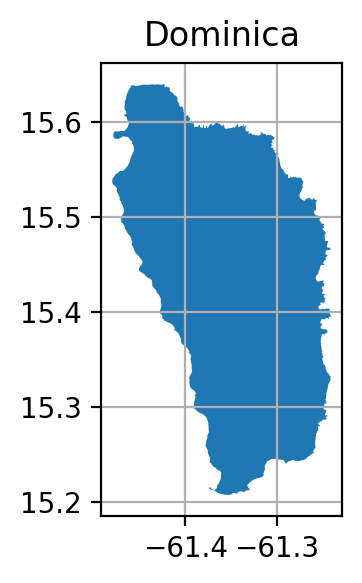

In [5]:
# Quick plot of Dominica outline in WGS84
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
ax.grid(True)

dma.plot(ax=ax, legend=True)
ax.set_title("Dominica")

## Whale sighting data

In [6]:
# Read in whale sightings dataset
dma_whale_data = gpd.read_file(whales_CSV)
dma_whale_data.head()

,field_1,GPStime,Lat,Long,geometry
0,0,2005-01-15 07:43:27,15.36977117,-61.49328433,None
1,1,2005-01-15 08:07:13,15.3834075,-61.503702,None
2,2,2005-01-15 08:31:17,15.38106333,-61.50486067,None
3,3,2005-01-15 09:19:10,15.33532083,-61.46858117,None
4,4,2005-01-15 10:08:00,15.294224,-61.45318517,None


In [7]:
# Convert csv columns into geometry of spatial geodataframe
geometry = gpd.points_from_xy(dma_whale_data.Long, dma_whale_data.Lat,crs=geodetic_EPSG)
dma_whale_data["geometry"] = geometry
dma_whale_data.head()

,field_1,GPStime,Lat,Long,geometry
0,0,2005-01-15 07:43:27,15.36977117,-61.49328433,POINT (-61.49328 15.36977)
1,1,2005-01-15 08:07:13,15.3834075,-61.503702,POINT (-61.50370 15.38341)
2,2,2005-01-15 08:31:17,15.38106333,-61.50486067,POINT (-61.50486 15.38106)
3,3,2005-01-15 09:19:10,15.33532083,-61.46858117,POINT (-61.46858 15.33532)
4,4,2005-01-15 10:08:00,15.294224,-61.45318517,POINT (-61.45319 15.29422)


In [8]:
dma_whale_data_proj = dma_whale_data.copy()

# Reproject the geometries by replacing the values with projected ones
dma_whale_data_proj['geometry'] = dma_whale_data_proj['geometry'].to_crs(epsg=projected_EPSG)

In [9]:
dma_whale_data_proj = dma_whale_data.copy()

# Reproject the geometries by replacing the values with projected ones
dma_whale_data_proj['geometry'] = dma_whale_data_proj['geometry'].to_crs(epsg=projected_EPSG)
dma_whale_data_proj.head()

,field_1,GPStime,Lat,Long,geometry
0,0,2005-01-15 07:43:27,15.36977117,-61.49328433,POINT (453414.693 1698559.951)
1,1,2005-01-15 08:07:13,15.3834075,-61.503702,POINT (452293.279 1700065.539)
2,2,2005-01-15 08:31:17,15.38106333,-61.50486067,POINT (452169.541 1699805.987)
3,3,2005-01-15 09:19:10,15.33532083,-61.46858117,POINT (456075.021 1694756.090)
4,4,2005-01-15 10:08:00,15.294224,-61.45318517,POINT (457738.945 1690214.877)


### Create grid

In [10]:
# Get total extent of whale sightings data to develop 2000m resolution grid
xmin, ymin, xmax, ymax = dma_whale_data_proj.total_bounds
cell_size = 2000

cols = list(np.arange(xmin, xmax + cell_size, cell_size))
rows = list(np.arange(ymin, ymax + cell_size, cell_size))

def make_cell(x, y, cell_size):
    ring = [
        (x, y),
        (x + cell_size, y),
        (x + cell_size, y + cell_size),
        (x, y + cell_size)
    ]
    cell = Polygon(ring)
    return cell

cells = []
for x in cols:
    for y in rows:
        cell = make_cell(x, y, cell_size)
        cells.append(cell)
        
grid = gpd.GeoDataFrame({'geometry': cells}, crs=2002)
grid.to_file("grid.shp")

### Speed Reduction Zone

In [11]:
# Subset grid for grid cells with more than 20 whale sightings
joined = gpd.sjoin(grid,dma_whale_data_proj, how="inner")
grid['count'] = joined.groupby(joined.index).count()['index_right']
above_20_obs = grid[grid['count'] > 20]
# Convert the selected grid cells into a single zone
speed_reduction_union = above_20_obs.geometry.unary_union
speed_reduction_zone = speed_reduction_union.convex_hull
speed_reduc_zone_gdf = gpd.GeoDataFrame(index=[0], crs=projected_EPSG, geometry=[speed_reduction_zone])

Text(0.5, 0.01, 'Figure 1. Speed reduction zone (red) located off of the coast of Dominica (blue).\n Vessels in this area must not exceed 10kts to reduce the negative effects of ship traffic on sperm whales and tourism.')

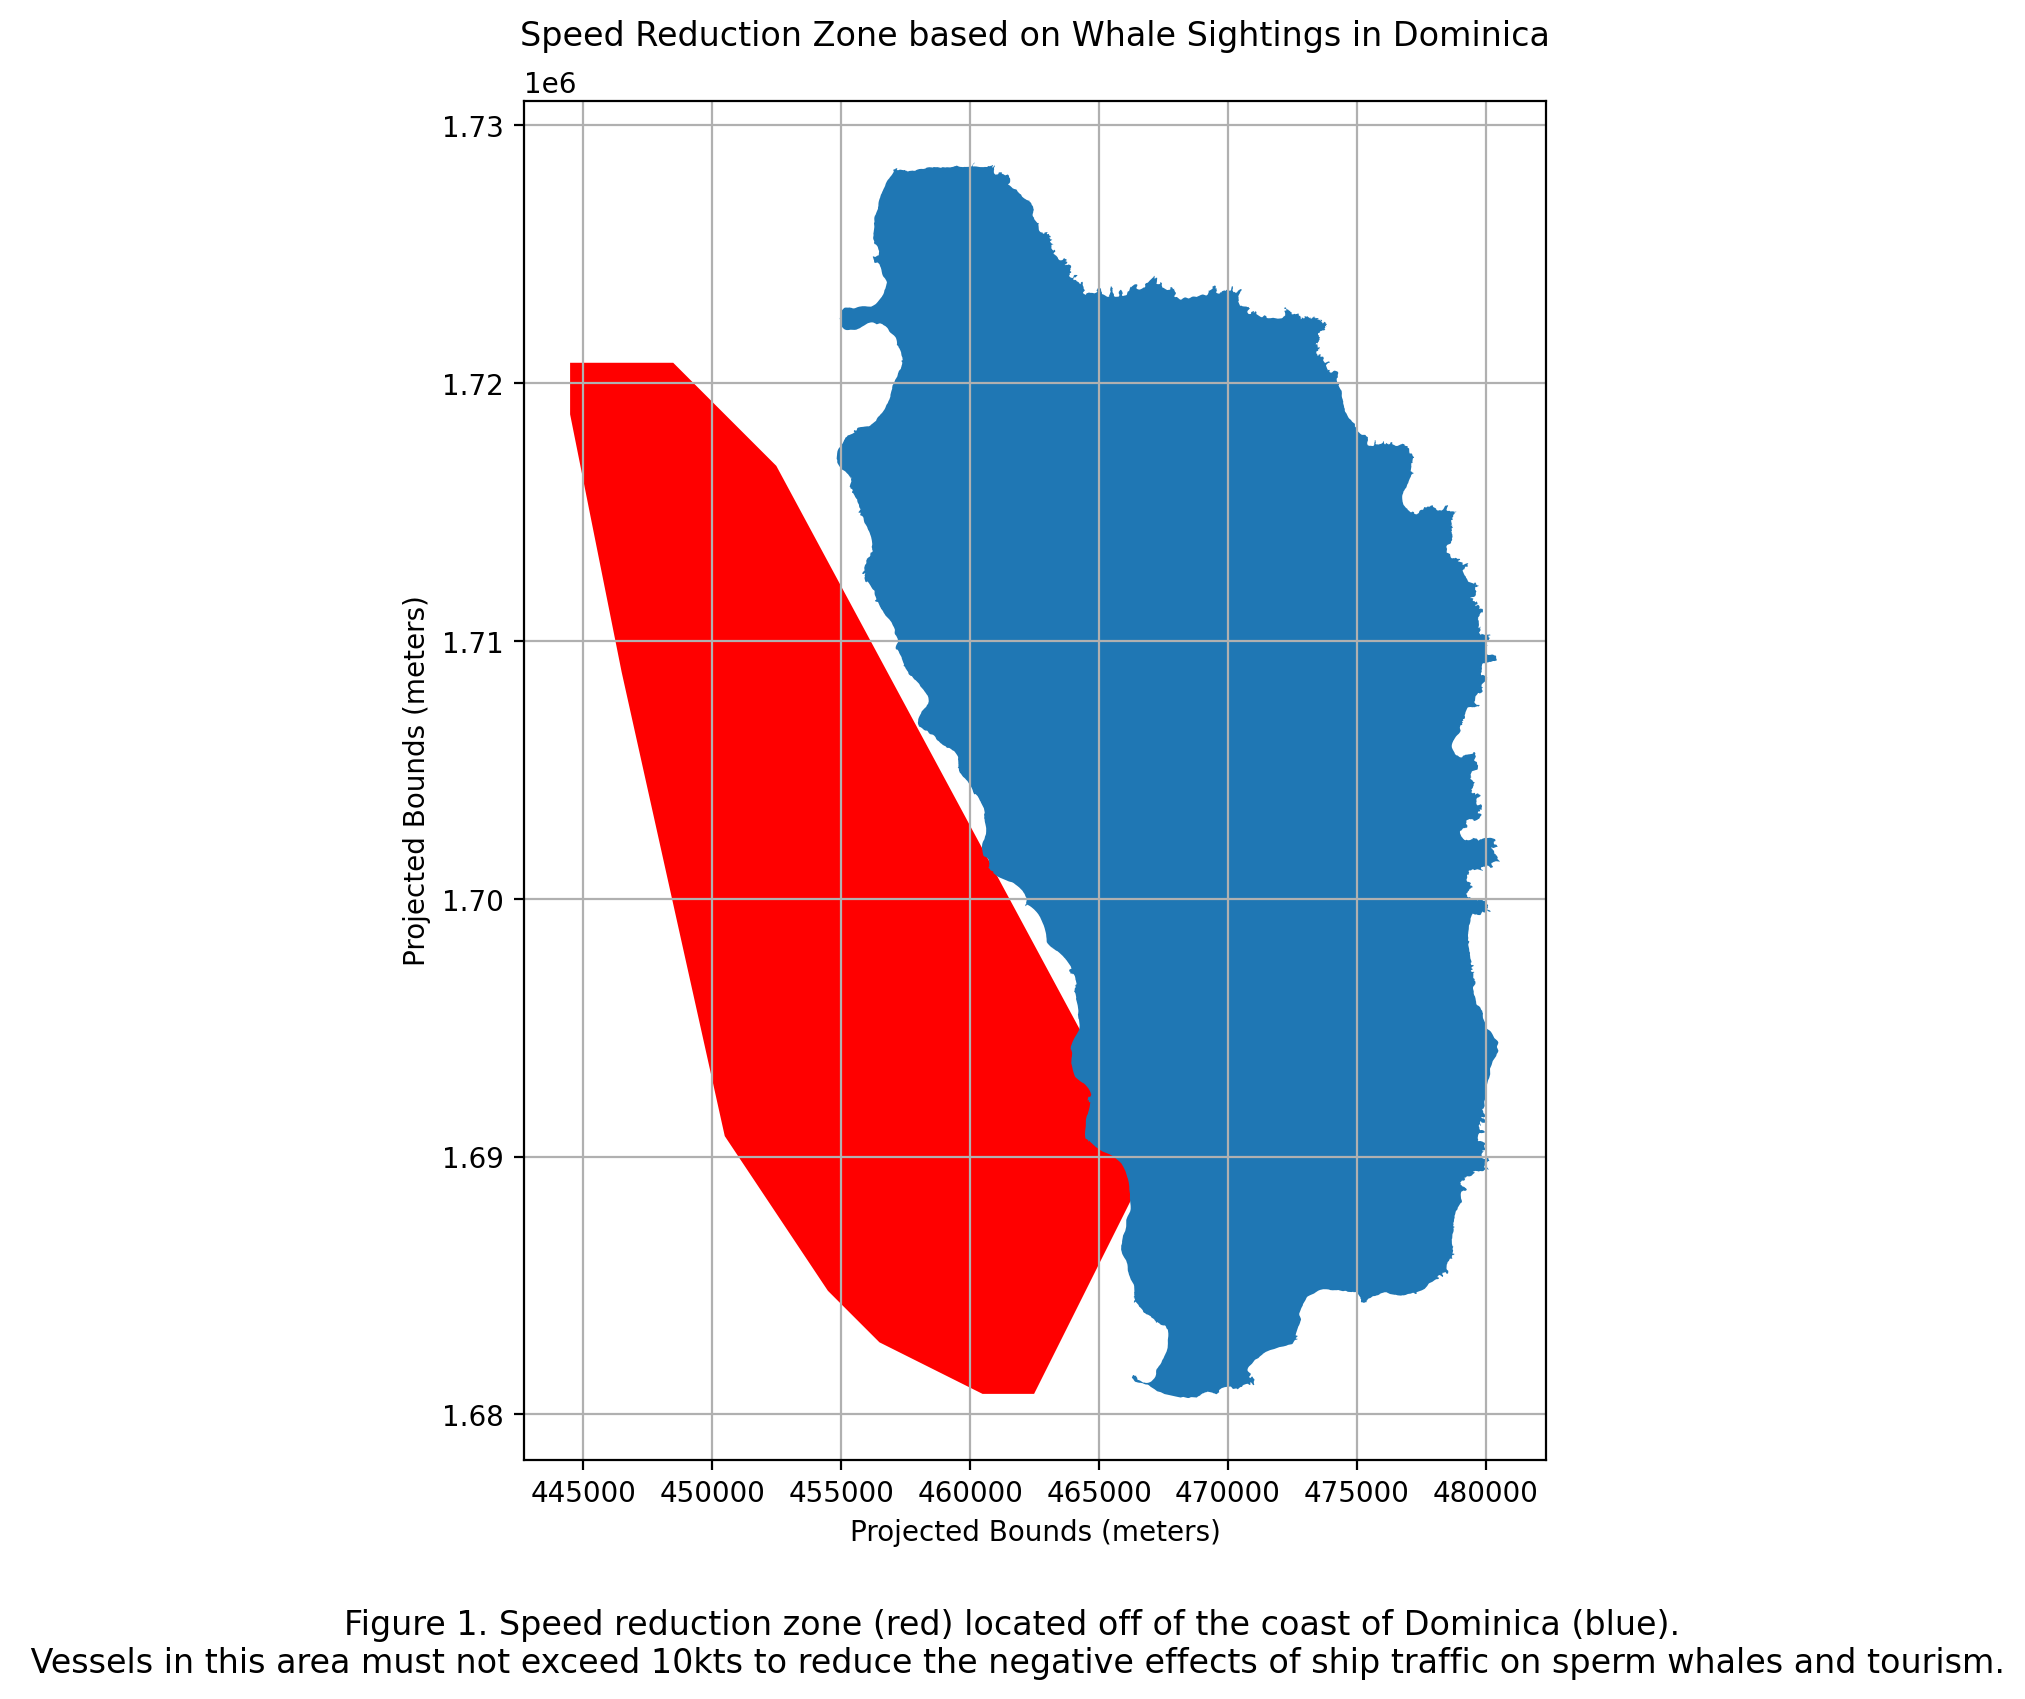

In [12]:
# Plot speed reduction zone and Dominica
fig, ax = plt.subplots(figsize=(9, 9), dpi=200)
ax.grid(True)
speed_reduc_zone_gdf.plot(ax=ax, legend=True, facecolor = "red", lw=0.5)
dma_proj = dma.to_crs(crs=projected_EPSG)
dma_proj.plot(ax=ax)
ax.set_title("Speed Reduction Zone based on Whale Sightings in Dominica", pad = 20)
ax.set_xlabel("Projected Bounds (meters)")
ax.set_ylabel("Projected Bounds (meters)")
txt="Figure 1. Speed reduction zone (red) located off of the coast of Dominica (blue).\n Vessels in this area must not exceed 10kts to reduce the negative effects of ship traffic on sperm whales and tourism."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

## Vessel data

In [13]:
# Read in vessel data
vessel_data = gpd.read_file(vessels_CSV)

In [14]:
# Convert lat lon in csv into spatial geometry
geometry = gpd.points_from_xy(vessel_data.LON, vessel_data.LAT,crs=geodetic_EPSG)
vessel_data["geometry"] = geometry 
vessel_data_proj = vessel_data.copy()
# Reproject the geometries by replacing the values with projected ones
vessel_data_proj['geometry'] = vessel_data_proj['geometry'].to_crs(epsg=projected_EPSG)

In [15]:
# Convert TIMESTAMP string to datetime64 format
vessel_data_proj["datetime"] = pd.to_datetime(vessel_data_proj['TIMESTAMP'])

In [16]:
# Subset vessels within the whale habitat
whale_habitat = speed_reduc_zone_gdf.dissolve()
habitat_mask = vessel_data_proj.within(whale_habitat.at[0,'geometry'])
vessel_subset = vessel_data_proj.loc[habitat_mask]

In [17]:
# Sort values and copy vessel subset to shift it by one row
vessel_subset = vessel_subset.sort_values(["MMSI", "datetime"])
vessel_subset_copy = vessel_subset.copy()
vessel_subset_copy_shift = vessel_subset_copy.shift(1)

In [18]:
# Join orginal vessel subset with shifted copy
joined_vessel_subset = vessel_subset_copy_shift.join(vessel_subset_copy, rsuffix = "_initial")

In [19]:
indiv_vessels = joined_vessel_subset[joined_vessel_subset['MMSI'] == joined_vessel_subset['MMSI_initial']]
indiv_vessels.sort_values(["MMSI", "datetime"])

,field_1,MMSI,LON,LAT,TIMESTAMP,geometry,datetime,field_1_initial,MMSI_initial,LON_initial,LAT_initial,TIMESTAMP_initial,geometry_initial,datetime_initial
235018,235025,203106200,-61.40929,15.21021,2015-02-25 15:32:20,POINT (462476.396 1680935.224),2015-02-25 15:32:20,235018,203106200,-61.41107,15.21436,2015-02-25 15:34:50,POINT (462283.995 1681393.698),2015-02-25 15:34:50
235000,235018,203106200,-61.41107,15.21436,2015-02-25 15:34:50,POINT (462283.995 1681393.698),2015-02-25 15:34:50,235000,203106200,-61.41427,15.22638,2015-02-25 15:42:19,POINT (461936.769 1682722.187),2015-02-25 15:42:19
234989,235000,203106200,-61.41427,15.22638,2015-02-25 15:42:19,POINT (461936.769 1682722.187),2015-02-25 15:42:19,234989,203106200,-61.41553,15.2353,2015-02-25 15:47:19,POINT (461798.818 1683708.377),2015-02-25 15:47:19
234984,234989,203106200,-61.41553,15.2353,2015-02-25 15:47:19,POINT (461798.818 1683708.377),2015-02-25 15:47:19,234984,203106200,-61.41687,15.23792,2015-02-25 15:49:50,POINT (461654.150 1683997.765),2015-02-25 15:49:50
234972,234984,203106200,-61.41687,15.23792,2015-02-25 15:49:50,POINT (461654.150 1683997.765),2015-02-25 15:49:50,234972,203106200,-61.41851,15.24147,2015-02-25 15:54:49,POINT (461476.997 1684389.925),2015-02-25 15:54:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259103,259118,983191049,-61.38323,15.29282,2015-02-19 19:44:46,POINT (465249.261 1690079.703),2015-02-19 19:44:46,259103,983191049,-61.38322,15.2927,2015-02-19 19:50:45,POINT (465250.372 1690066.434),2015-02-19 19:50:45
259094,259103,983191049,-61.38322,15.2927,2015-02-19 19:50:45,POINT (465250.372 1690066.434),2015-02-19 19:50:45,259094,983191049,-61.38328,15.29259,2015-02-19 19:55:09,POINT (465243.965 1690054.249),2015-02-19 19:55:09
258954,259094,983191049,-61.38328,15.29259,2015-02-19 19:55:09,POINT (465243.965 1690054.249),2015-02-19 19:55:09,258954,983191049,-61.38344,15.2932,2015-02-19 20:51:12,POINT (465226.597 1690121.667),2015-02-19 20:51:12
258930,258954,983191049,-61.38344,15.2932,2015-02-19 20:51:12,POINT (465226.597 1690121.667),2015-02-19 20:51:12,258930,983191049,-61.38329,15.29258,2015-02-19 21:02:54,POINT (465242.895 1690053.140),2015-02-19 21:02:54


### Shipping Impact Calculations

In [20]:
indiv_vessels = indiv_vessels.set_geometry("geometry")

# Find distance between observations in same row
indiv_vessels['dist_from_initial_m'] = indiv_vessels.distance(indiv_vessels['geometry_initial'])

# Find time difference between each observation to the next
indiv_vessels['time_difference'] = indiv_vessels['datetime_initial']-indiv_vessels['datetime']

In [21]:
indiv_vessels['time_to_dist_sec'] = indiv_vessels['time_difference'].dt.seconds

# Find average speed between each observation to the next
indiv_vessels['speed_mpersec'] = indiv_vessels['dist_from_initial_m']/ indiv_vessels['time_to_dist_sec'] 

# convert m to seamile, 1 seamile = 1852 meters
indiv_vessels['dist_from_initial_seamile'] = indiv_vessels['dist_from_initial_m'] / meters_per_nm

# time in second to travel distance at 10 knots, 1 hr = 3,600 sec
indiv_vessels['time_to_dist_10knots_sec'] = (indiv_vessels['dist_from_initial_seamile'] / 10) * sec_per_hr 

# difference between actual time taken and time taken at speed of 10 knots
indiv_vessels['timediff_due_to_10kts_sec'] = indiv_vessels['time_to_dist_10knots_sec'] - indiv_vessels['time_to_dist_sec']

### Anticipated Cumulative Shipping Impact from Proposed Speed Reduction Zone

In [22]:
# Compute total time of impact due to speed reduction to 10 knots 
impacted_shipping_vessels = indiv_vessels[indiv_vessels['timediff_due_to_10kts_sec'] > 0]
total_impact_days = (impacted_shipping_vessels['timediff_due_to_10kts_sec'].sum())/(sec_per_hr * hr_per_day)
print(round(total_impact_days, 3), "days in increased travel time for all vessels")

28.688 days in increased travel time for all vessels
